In [9]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 39.5/39.5 MB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import gymnasium as gym
import os
from ale_py import ALEInterface, roms
import time
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:

env = gym.make("ALE/Frogger-v5", render_mode='human')

initial_state = env.reset()
while True:
    env.render()


    # Take a step (0: LEFT, 1: DOWN, 2: RIGHT, 3: UP)
    action = env.action_space.sample()
    new_state, reward, terminated, truncated, info = env.step(action)
    print(action)

    env.render()

time.sleep(5)

env.reset()
env.close()

ModuleNotFoundError: No module named 'gymnasium'

In [2]:
env = gym.make("ALE/Frogger-v5", render_mode='rgb_array')
initial_state = env.reset()

In [3]:
screenshot=env.render()

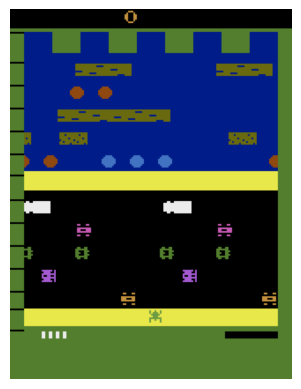

In [4]:
plt.imshow(screenshot)
plt.axis("off")
plt.show()

In [22]:
def gary(image):
    gar=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gar, (84, 84), interpolation=cv2.INTER_AREA)
    
    # Normalize pixel values (scale to 0-1)
    normalized = resized / 255.0

    return normalized

    
    

In [23]:
pros=gary(screenshot)

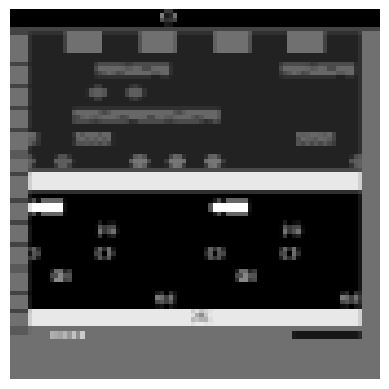

In [25]:
plt.imshow(pros,cmap='gray')
plt.axis("off")
plt.show()